In [1]:
from pycoingecko import CoinGeckoAPI
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [2]:
# Calling Coin Gecko API
## Import the data
#cg = CoinGeckoAPI()
#coins_market = cg.get_coins_markets('usd')
#df_coins_market = pd.DataFrame(coins_market)

In [3]:
## Get the prices for each crypto for 365 days (01.01.19 - 31.12.19)
#prices = []
#for i in df_coins_market['id']:
#    a = cg.get_coin_market_chart_range_by_id(i, 'usd', 1546300800, 1577750400)
#    b = a['prices']
#    c = []
#   for j in range(len(b)):
#        c.append(b[j][1])
#    prices.append([i, c])
#del a, b, c, i, j

## Creating the prices, returns and market caps dataframes

#frame = pd.DataFrame(prices)
#coins = frame[1].apply(pd.Series)
#frame = coins.set_index(frame[0])
#frame = frame.dropna(axis=0).transpose()
#frame.to_csv('CC_Prices.csv',index=True,header=True)

# Returns
#returns_data = np.log(frame) - np.log(frame.shift(1))
#returns_data = returns_data[1:]
#returns_data.to_csv('CC_LogReturns.csv', index=True, header=True)

# To ensure working with same figures, we will not generate above df each time. 
# Then, we saved them into csv to import them just below. 

# Importing different df
# Prices
prices_data = pd.read_csv('CC_Prices.csv')
prices_data = prices_data.drop(['Unnamed: 0'], axis = 1)
# Returns
returns_data = pd.read_csv('CC_LogReturns.csv')
returns_data = returns_data.drop(['Unnamed: 0'], axis = 1)
# Market caps
market_cap = pd.read_csv('CC_MarketCaps.csv')
market_cap = market_cap.drop(['Unnamed: 0'], axis = 1)

In [4]:
# Exploratory Analysis

# 1) Plotting the prices over the period of various combinations of coins
# 2) CCs returns and market caps
# 3) Stationarity test
# 4) Autocorrelation test
# 5) Statistical summary of cc
# 6) Scatterplot of correlated cc
# 7) Explorative Clustering with K-Means

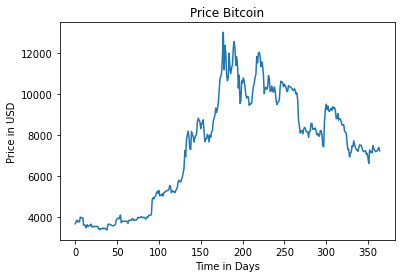

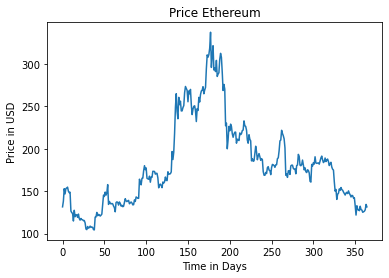

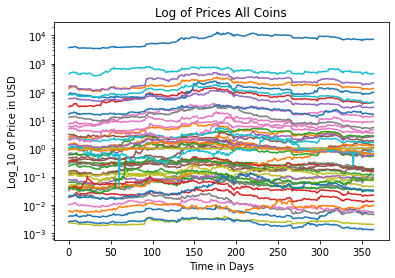

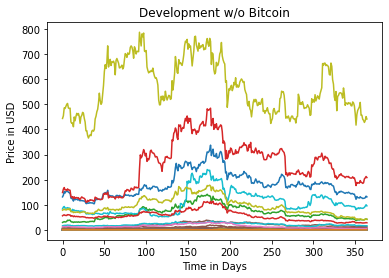

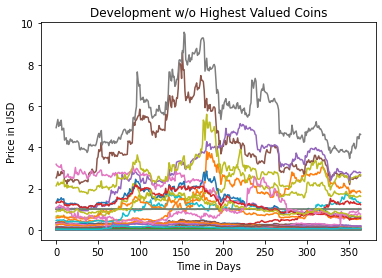

<Figure size 432x288 with 0 Axes>

In [5]:
# Exploratory Analysis
# 1) Plotting the prices over the period of various combinations of coins

plt.plot(prices_data['bitcoin'])
plt.title('Price Bitcoin')
plt.xlabel('Time in Days')
plt.ylabel('Price in USD')
plt.show()
plt.savefig('Data_Analysis/Bitcoin.jpeg', bbox_inches='tight')
plt.clf()

plt.plot(prices_data['ethereum'])
plt.title('Price Ethereum')
plt.xlabel('Time in Days')
plt.ylabel('Price in USD')
plt.show()
plt.savefig('Data_Analysis/Ether.jpeg', bbox_inches='tight')
plt.clf()

plt.plot(prices_data)
plt.yscale('log')
plt.title('Log of Prices All Coins')
plt.xlabel('Time in Days')
plt.ylabel('Log_10 of Price in USD')
plt.show()
plt.savefig('Data_Analysis/Log_All_coins.jpeg', bbox_inches='tight')
plt.clf()

plt.plot(prices_data.drop('bitcoin', axis=1))
plt.title('Development w/o Bitcoin')
plt.xlabel('Time in Days')
plt.ylabel('Price in USD')
plt.show()
plt.savefig('Data_Analysis/w_o_Bitcoin.jpeg',bbox_inches='tight')
plt.clf()

plt.plot(prices_data.drop(['bitcoin', 'ethereum', 'dash', 'neo', 'zcash', 'maker', 'bitcoin-cash', 'litecoin', 'bitcoin-cash-sv', 'decred', 'bitcoin-gold', 'quant-network', 'binancecoin'], axis=1))
plt.title('Development w/o Highest Valued Coins')
plt.xlabel('Time in Days')
plt.ylabel('Price in USD')
plt.show()
plt.savefig('Data_Analysis/w_o_highest.jpeg', bbox_inches='tight')
plt.clf()

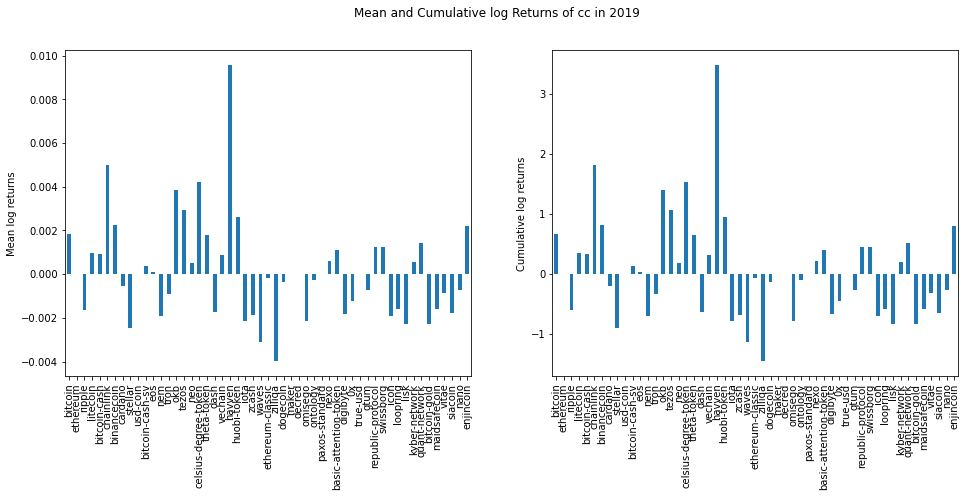

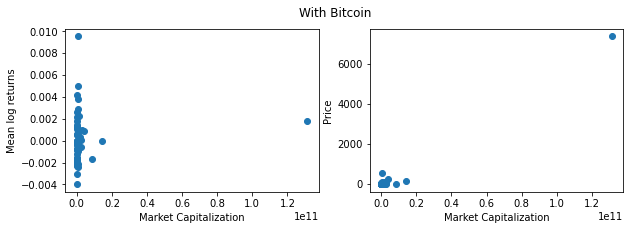

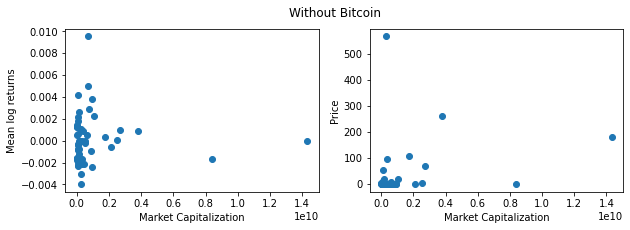

In [6]:
# Exploratory Analysis
# 2) CCs logreturns and prices/market caps

# 2.A) CCs logreturns

mean_returns = returns_data.mean(axis=0) # mean of 2019 log returns for each cc
cum_returns = returns_data.sum(axis=0) # cumulative log returns in 2019 for each cc

# Plotting mean and cumulative returns of 2019 for each cc
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
mean_returns.plot(ax=axes[0], kind='bar')
axes[0].set_ylabel('Mean log returns')
cum_returns.plot(ax=axes[1], kind='bar')
axes[1].set_ylabel('Cumulative log returns')
fig.set_size_inches(16, 6)
fig.suptitle('Mean and Cumulative log Returns of cc in 2019')
fig.savefig('Data_Analysis/returns.jpeg', transparent=True,bbox_inches='tight')

# 2.B) Market Caps consideration with mean returns and prices

mean_price = prices_data.mean()

# 2.B.i) Scatter plots of MarketCap-MeanReturns and MarketCaps-Prices (with bitcoin)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
axes[0].scatter(market_cap, mean_returns)
axes[0].set_xlabel('Market Capitalization')
axes[0].set_ylabel('Mean log returns')
axes[1].scatter(market_cap, mean_price)
axes[1].set_xlabel('Market Capitalization')
axes[1].set_ylabel('Price')
fig.suptitle('With Bitcoin')
fig.savefig('Data_Analysis/scatter.jpeg', transparent=True,bbox_inches='tight')

# 2.B.ii) Scatter plots of MarketCap-MeanReturns and MarketCaps-Prices (without bitcoin)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
axes[0].scatter(market_cap[1:], mean_returns[1:])
axes[0].set_xlabel('Market Capitalization')
axes[0].set_ylabel('Mean log returns')
axes[1].scatter(market_cap[1:], mean_price[1:])
axes[1].set_xlabel('Market Capitalization')
axes[1].set_ylabel('Price')
fig.suptitle('Without Bitcoin')
fig.savefig('Data_Analysis/scatter_without.jpeg', transparent=True,bbox_inches='tight')

In [7]:
# Exploratory Analysis
# 3) Stationarity Test

# initialization
cc_names = returns_data.columns # columns names of returns db (≠ cryptos)
nb_cc = len(cc_names) # number of cc

# testing stationarity, from https://www.hackdeploy.com/augmented-dickey-fuller-test-in-python/

class StationarityTests: # implementing a class of functions to test stationarity
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None

    def ADF_Stationarity_Test(self, timeseries, printResults = True):

        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value

            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

statio_cc = [] # creating a matrix which will give if cc are stationary or not
for i in cc_names:
    sTest = StationarityTests()
    sTest.ADF_Stationarity_Test(returns_data[i],printResults = True)
    print("Is the time series stationary? {0}".format(sTest.isStationary))
    statio_cc.append([i,sTest.isStationary])

statio_cc = pd.DataFrame(statio_cc) # converting it to a panda df
statio_cc.index = cc_names; statio_cc.columns = ["cc","Stationary"]
statio_cc = statio_cc['Stationary']

# exporting it to a csv
statio_cc.to_csv('Data_Analysis/statio_cc.csv',index = True,header = True) 

del i,sTest # deleting useless variables

Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -19.786298
P-Value                   0.000000
# Lags Used               0.000000
# Observations Used     363.000000
Critical Value (1%)      -3.448494
Critical Value (5%)      -2.869535
Critical Value (10%)     -2.571029
dtype: float64
Is the time series stationary? True
Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -20.576621
P-Value                   0.000000
# Lags Used               0.000000
# Observations Used     363.000000
Critical Value (1%)      -3.448494
Critical Value (5%)      -2.869535
Critical Value (10%)     -2.571029
dtype: float64
Is the time series stationary? True
Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.510723e+01
P-Value                 7.787822e-28
# Lags Used             1.000000e+00
# Observations Used     3.620000e+02
Critical Value (1%)    -3.448544e+00
Critical Value (5%)    -2.869557e+00
Critical Value (10%)   -2.571041e+00
dtype: float64
Is the time series s

Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -20.451431
P-Value                   0.000000
# Lags Used               0.000000
# Observations Used     363.000000
Critical Value (1%)      -3.448494
Critical Value (5%)      -2.869535
Critical Value (10%)     -2.571029
dtype: float64
Is the time series stationary? True
Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -7.985504e+00
P-Value                 2.555473e-12
# Lags Used             8.000000e+00
# Observations Used     3.550000e+02
Critical Value (1%)    -3.448906e+00
Critical Value (5%)    -2.869716e+00
Critical Value (10%)   -2.571126e+00
dtype: float64
Is the time series stationary? True
Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.503771e+01
P-Value                 9.694212e-28
# Lags Used             1.000000e+00
# Observations Used     3.620000e+02
Critical Value (1%)    -3.448544e+00
Critical Value (5%)    -2.869557e+00
Critical Value (10%)   -2.571041e+00
dtype: float64
Is the

In [8]:
# printing last df of interest: all cryptos seem to be stationary = good news
print("True means that the considered cc is stationary while False means the opposite…")
print("Houra. All cryptos seem to be stationary. Then, we can keep working with these time series.")

print(statio_cc)


True means that the considered cc is stationary while False means the opposite…
Houra. All cryptos seem to be stationary. Then, we can keep working with these time series.
bitcoin                  True
ethereum                 True
ripple                   True
litecoin                 True
bitcoin-cash             True
chainlink                True
binancecoin              True
cardano                  True
stellar                  True
usd-coin                 True
bitcoin-cash-sv          True
eos                      True
nem                      True
tron                     True
okb                      True
tezos                    True
neo                      True
celsius-degree-token     True
theta-token              True
dash                     True
vechain                  True
havven                   True
huobi-token              True
iota                     True
zcash                    True
waves                    True
ethereum-classic         True
zilliqa           

4 cryptocurrencies show autocorrelation with at least one of their last 20 lags.


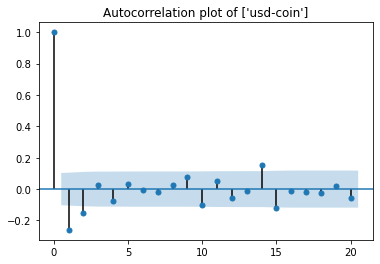

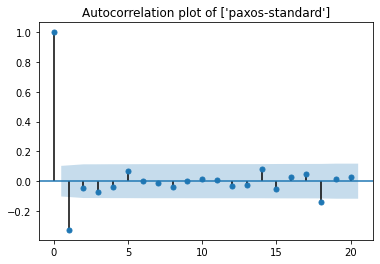

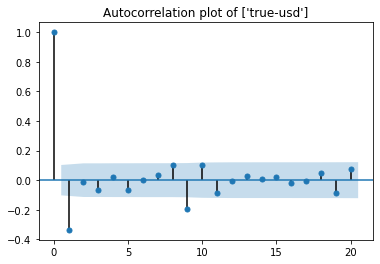

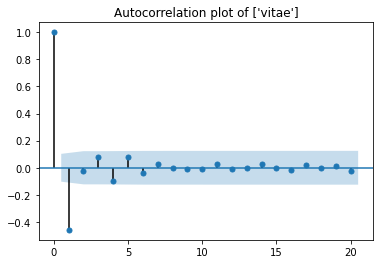

In [9]:
# Exploratory Analysis
# 4) Autocorrelation Test

# In this section, the autocorrelation of each cc is computed with 20 lags 
# Autocorrelation plots will be shown for autocorrelated cc

#plot_acf(returns_data['bitcoin'], lags = 20, alpha = 0.05)
#ac_bitcoin = acf(returns_data['bitcoin'],nlags=20)

#for i in range(len(ac_bitcoin)):
 #   if (ac_bitcoin[i]<0.035):
  #      print(ac_bitcoin[i])

lags_names = [] # useful for below
for i in range(0,21):
    lags_names.append('lag' + str(i))

autocorr_cc = pd.DataFrame(np.zeros((21,nb_cc))) # creating autocorrelation matrix
autocorr_cc.columns = cc_names # adding cryptos names
autocorr_cc.index = lags_names # adding lags names
autocorrelated_cc = [] # creating a list to add the autocorrelated cryptos

for i in range(nb_cc): # making a loop to determine which cryptos are autocorrelated and add them to the list
    ccname = cc_names[i]
    autocorr_cc[ccname] = acf(returns_data[ccname],nlags = 20, fft=False)
    for j in range(len(autocorr_cc)):
        lagnb = 'lag'+ str(j)
        ac = autocorr_cc[ccname][lagnb]
        if ((ac >= 0.25 or ac <= -0.25) and ac != 1.):
            autocorrelated_cc.append([ccname])
del ccname

print(str(len(autocorrelated_cc))+" cryptocurrencies show autocorrelation with at least one of their last 20 lags.")

for i in range(len(autocorrelated_cc)): # autocorrelation plots for cryptos in the list
    ccname = autocorrelated_cc[i]
    plot_acf(returns_data[ccname], lags = 20, alpha = 0.05,title = 'Autocorrelation plot of '+ str(ccname))
    plt.savefig('Data_Analysis/acplt'+  str(ccname) + '.jpeg',transparent=True)



          bitcoin      ethereum      ripple    litecoin  bitcoin-cash  \
count  364.000000  3.640000e+02  364.000000  364.000000    364.000000   
mean     0.001850  7.129810e-08   -0.001626    0.000961      0.000923   
std      0.035509  4.246187e-02    0.036729    0.048855      0.053251   
min     -0.150643 -1.753563e-01   -0.130690   -0.159533     -0.280861   
25%     -0.013290 -1.824251e-02   -0.016664   -0.025892     -0.020805   
50%      0.001023 -7.617596e-04   -0.001335   -0.000842     -0.002254   
75%      0.017332  1.888169e-02    0.011610    0.024168      0.023530   
max      0.159276  1.477720e-01    0.226891    0.261960      0.364697   

        chainlink  binancecoin     cardano     stellar    usd-coin  ...  \
count  364.000000   364.000000  364.000000  364.000000  364.000000  ...   
mean     0.004992     0.002261   -0.000532   -0.002448    0.000010  ...   
std      0.065036     0.044104    0.046071    0.041849    0.003273  ...   
min     -0.208088    -0.154145   -0.180399

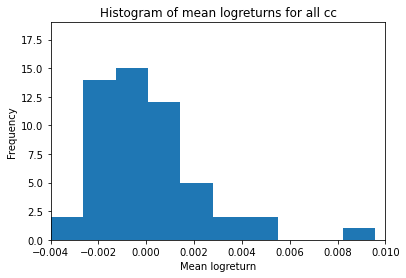

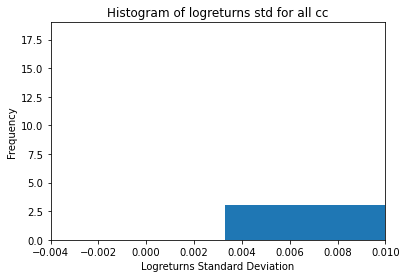

In [10]:
# Exploratory Analysis
# 5) Statistical summary of cc

# statistical summary of cryptos
summary_cc = returns_data.describe();
print(summary_cc)
summary_cc = summary_cc.transpose();

# plotting the histogram of logreturns mean for all cc
fig = plt.figure()
plt.hist(summary_cc['mean']) 
plt.xlabel('Mean logreturn')
plt.ylabel('Frequency')
plt.title('Histogram of mean logreturns for all cc')
plt.xlim(-0.004, 0.010)
plt.ylim(0, 19)
plt.savefig('Data_Analysis/LogReturnsMean_Histogram.jpeg',transparent=True)
plt.show()

# plotting the histogram of logreturns std for all cc
fig = plt.figure()
plt.hist(summary_cc['std']) 
plt.xlabel('Logreturns Standard Deviation')
plt.ylabel('Frequency')
plt.title('Histogram of logreturns std for all cc')
plt.xlim(-0.004, 0.010)
plt.ylim(0, 19)
plt.savefig('Data_Analysis/LogReturnsStd_Histogram.jpeg',transparent=True)
plt.show()

16 pairs of cryptocurrencies are highly correlated in their log returns
bitcoin is strongly correlated to ethereum


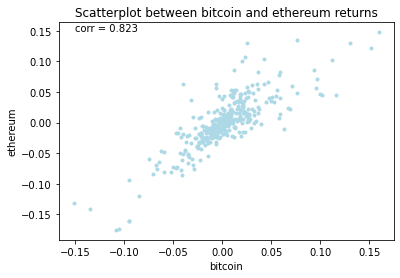

ethereum is strongly correlated to ripple


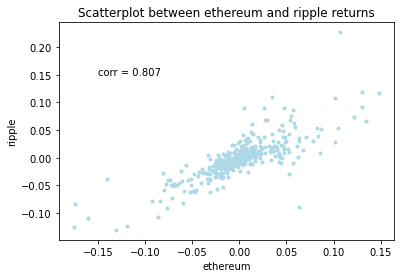

ethereum is strongly correlated to litecoin


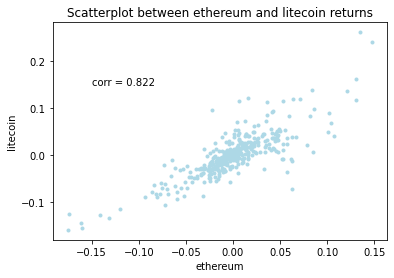

ethereum is strongly correlated to bitcoin-cash


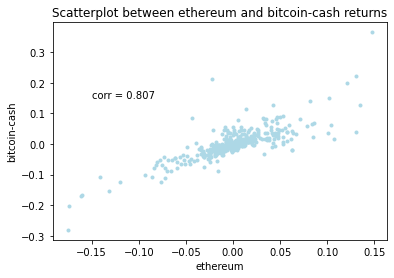

ethereum is strongly correlated to cardano


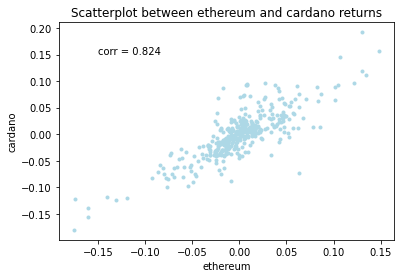

ethereum is strongly correlated to eos


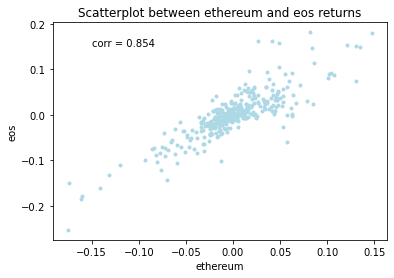

ethereum is strongly correlated to dash


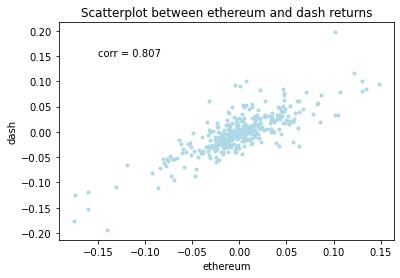

ripple is strongly correlated to cardano


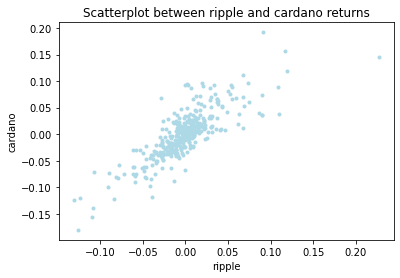

litecoin is strongly correlated to bitcoin-cash


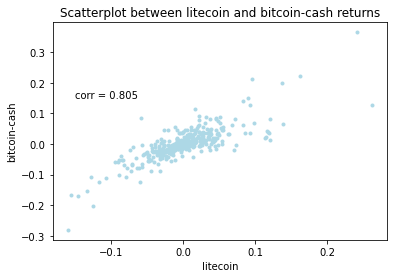

litecoin is strongly correlated to cardano


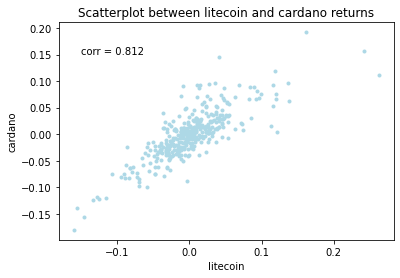

litecoin is strongly correlated to eos


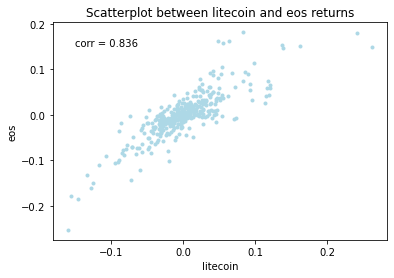

bitcoin-cash is strongly correlated to eos


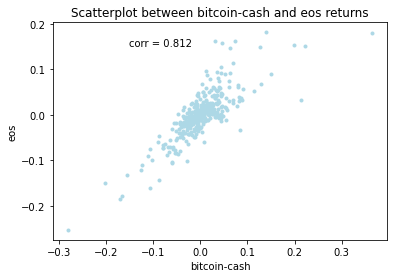

cardano is strongly correlated to eos


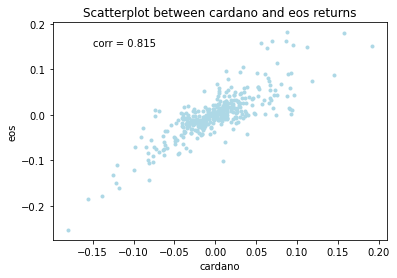

neo is strongly correlated to ontology


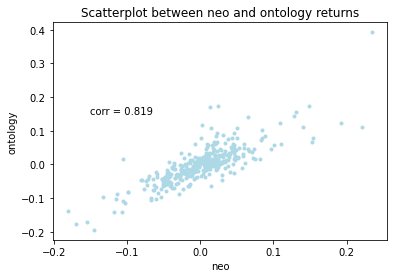

neo is strongly correlated to qtum


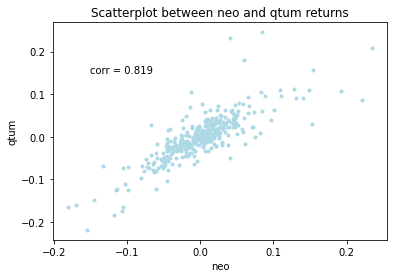

omisego is strongly correlated to qtum


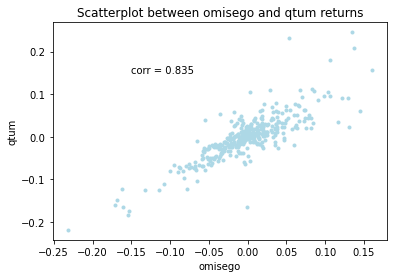

In [11]:
# Exploratory Analysis
# 6) Scatterplot of correlated cc

# correlation matrix of all cryptos logreturns
corr_matrix = pd.DataFrame(np.zeros((nb_cc,nb_cc)))
corr_matrix.index = corr_matrix.columns = cc_names
corr_matrix = returns_data.corr()
corr_matrix = round(corr_matrix,3)

# exporting it to csv and excel (useful for reporting)
corr_matrix.to_csv('Data_Analysis/cc_corrmatrix.csv', index=True, header=True)
corr_matrix.to_excel('Data_Analysis/cc_corrmatrix.xlsx',index=True,header=True)

# scatter plot between highly (negatively or positively) correlated cryptos

highcorr_matrix = pd.DataFrame(np.zeros((nb_cc,nb_cc)))
highcorr_matrix.index = highcorr_matrix.columns = cc_names
highcorr_cc = []
print("16 pairs of cryptocurrencies are highly correlated in their log returns")
for i in range(nb_cc): # just a for loop to determine what are the correlated cryptos
    abc = cc_names[i]
    for j in range(nb_cc):
        if (i<j):
            dcb = cc_names[j]
            corr = corr_matrix[abc][dcb]
            if ((corr >= 0.8 or corr <= -0.8) and corr != 1 ):
                highcorr_matrix[abc][dcb] = corr_matrix[abc][dcb]
                print(abc + ' is strongly correlated to ' + dcb)
                corr_str = str(round(corr,3))
                fig = plt.figure()
                ax = fig.add_subplot(111)
                ax.scatter(returns_data[abc],returns_data[dcb], color='lightblue', marker='.')
                ax.set(title='Scatterplot between '+abc+' and '+dcb+' returns',ylabel=dcb,xlabel=abc)
                ax.annotate('corr = '+corr_str,xy=(-0.15,0.15))
                plt.savefig('Data_Analysis/sc_'+ abc + '_' + dcb +'.jpeg',transparent=True)
                plt.show()
                highcorr_cc.append([abc,dcb,corr])

highcorr_cc = pd.DataFrame(highcorr_cc)
highcorr_cc.columns = ["Crypto 1","Crypto 2","Pair correlation"]
highcorr_cc.to_csv('Data_Analysis/highcorr_cc.csv', index=True, header=True)
#sns.regplot(x=abc,y=dcb,ci = None,data=ret_cc)

In [12]:
highcorr_cc

,Crypto 1,Crypto 2,Pair correlation
0,bitcoin,ethereum,0.823
1,ethereum,ripple,0.807
2,ethereum,litecoin,0.822
3,ethereum,bitcoin-cash,0.807
4,ethereum,cardano,0.824
5,ethereum,eos,0.854
6,ethereum,dash,0.807
7,ripple,cardano,0.814
8,litecoin,bitcoin-cash,0.805
9,litecoin,cardano,0.812


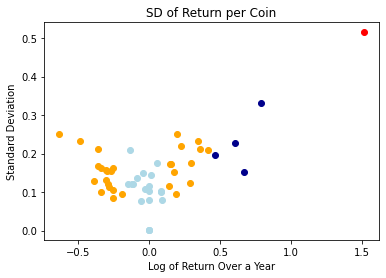

In [13]:
#Preparing the data
log_frame = np.log10(prices_data)
log_return = list()
volatility = list()
for i in range (0, prices_data.shape[1]):
    log_return.append(i)
    volatility.append(i)
    log_return[i]= log_frame.iloc[364][i] - log_frame.iloc[0][i]
    aux = np.std(log_frame.iloc[:,[i]]) #change here to get other diagram
    volatility[i] = aux[0]

##### Creating the Clusters
db_vol_ret =pd.DataFrame(data=log_return,columns=['return'])
db_vol_ret['volatillity'] = volatility
n_kmeans = 5
km = KMeans(n_clusters=n_kmeans)
y_predicted = km.fit_predict(db_vol_ret)
cols=prices_data.columns
db_vol_ret.index=cols
db_vol_ret['cluster'] = y_predicted

##plotting the result
df = db_vol_ret
df1= df[df.cluster == 0]
df2= df[df.cluster == 1]
df3= df[df.cluster == 2]
df4= df[df.cluster == 3]
df5= df[df.cluster == 4]

plt.scatter(df1['return'],df1['volatillity'],color='lightblue')
plt.scatter(df2['return'],df2['volatillity'],color='red')
plt.scatter(df3['return'],df3['volatillity'],color='orange')
plt.scatter(df4['return'],df4['volatillity'],color='darkblue')
plt.scatter(df5['return'],df5['volatillity'],color='orange')
plt.xlabel('Log of Return Over a Year')
plt.ylabel('Standard Deviation')
plt.title('SD of Return per Coin')
plt.savefig('Data_Analysis/K-Means_Explorative.jpeg',transparent=True)

In [14]:
# Clustering

# 1) Rolling windows computation for each variable
# 2) PCA: Principal Components Analysis followed by a k-means clustering algorithm on its components
    # 2.a) Application on a single window
    # 2.b) Application on all rolling windows
# 3) LFM: Linear Factor Model followed by a k-means clustering algorithm on its factors
    # 3.a) Application on a single window
    # 3.b) Application on all rolling windows

In [15]:
# Clustering

# 1) Rolling windows computation for each variable

window_size = 25 # determining the size of the rolling windows we are going to compute

# Mean
window_mean = returns_data.rolling(window=window_size).mean()
window_mean = window_mean.dropna(axis=0)

# Variance
window_var = returns_data.rolling(window=window_size).var()
window_var = window_var.dropna(axis=0)

# Skewness (IMPORTANT: need to take rolling window of 3 to calculate it)
window_skew = returns_data.rolling(window=window_size).skew()
window_skew = window_skew.dropna(axis=0)

# Kurtosis (IMPORTANT: need to take rolling window of 4 to calculate it)
window_kurt = returns_data.rolling(window=window_size).kurt()
window_kurt = window_kurt.dropna(axis=0)

# Quantile 0.05
window_005_quantile = returns_data.rolling(window=window_size).quantile(0.05)
window_005_quantile = window_005_quantile.dropna(axis=0)

# Quantile 0.10
window_010_quantile = returns_data.rolling(window=window_size).quantile(0.10)
window_010_quantile = window_010_quantile.dropna(axis=0)

# Quantile 0.15
window_015_quantile = returns_data.rolling(window=window_size).quantile(0.15)
window_015_quantile = window_015_quantile.dropna(axis=0)

# Quantile 0.85
window_085_quantile = returns_data.rolling(window=window_size).quantile(0.85)
window_085_quantile = window_085_quantile.dropna(axis=0)

# Quantile 0.90
window_090_quantile = returns_data.rolling(window=window_size).quantile(0.90)
window_090_quantile = window_090_quantile.dropna(axis=0)

# Quantile 0.95
window_095_quantile = returns_data.rolling(window=window_size).quantile(0.95)
window_095_quantile = window_095_quantile.dropna(axis=0)


In [16]:
# Clustering

# 2) PCA: Principal Components Analysis followed by a k-means clustering algorithm on its components
    # 2.a) Application on a single window

# Initialization: Df creation for the first window
frames = [window_mean.iloc[0], window_var.iloc[0],window_skew.iloc[0],
          window_kurt.iloc[0], window_005_quantile.iloc[0], window_010_quantile.iloc[0],
          window_015_quantile.iloc[0], window_085_quantile.iloc[0], window_090_quantile.iloc[0],
          window_095_quantile.iloc[0]]
frames = pd.concat(frames, axis=1)

scaler = MinMaxScaler()
scaler.fit(frames)
frames_norm = pd.DataFrame(scaler.transform(frames),index=frames.index) 
frames_norm.columns = ("Mean","Variance","Skewness","Kurtosis","Q.05","Q.10","Q.15","Q.85","Q.90","Q.95")
frames_norm # final dataframe of the different variables (moments + quantiles) for each cc

,Mean,Variance,Skewness,Kurtosis,Q.05,Q.10,Q.15,Q.85,Q.90,Q.95
bitcoin,0.452785,0.036397,0.331646,0.533070,0.866977,0.857108,0.795706,0.126900,0.119378,0.150307
ethereum,0.373463,0.126541,0.490807,0.381679,0.717934,0.703016,0.617143,0.228206,0.234704,0.360786
ripple,0.394568,0.045151,0.243746,0.543274,0.828487,0.798767,0.754050,0.152035,0.147863,0.121812
litecoin,0.555107,0.127172,0.459584,0.269824,0.743675,0.729847,0.569958,0.324247,0.312669,0.277995
bitcoin-cash,0.350650,0.117031,0.310603,0.456292,0.745819,0.704867,0.573326,0.252540,0.219902,0.229036
chainlink,0.857243,0.285613,0.766090,0.086631,0.688798,0.631513,0.457865,0.571933,0.527172,0.653220
binancecoin,0.557537,0.078890,0.476226,0.248050,0.750718,0.795175,0.787277,0.247969,0.252299,0.225090
cardano,0.517659,0.135110,0.411017,0.281094,0.687142,0.687088,0.667592,0.344409,0.351540,0.347575
stellar,0.395852,0.063071,0.277525,0.586199,0.842281,0.811095,0.695320,0.152314,0.133515,0.199927
usd-coin,0.484375,0.000076,0.519645,0.000000,0.994371,0.990759,0.987988,0.006513,0.006007,0.003981


[0.18880196 0.04837439 0.03711979]


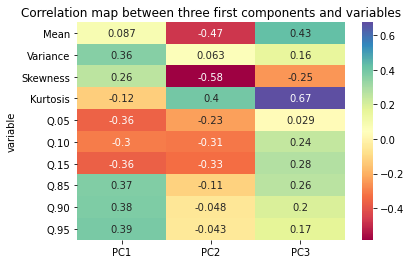

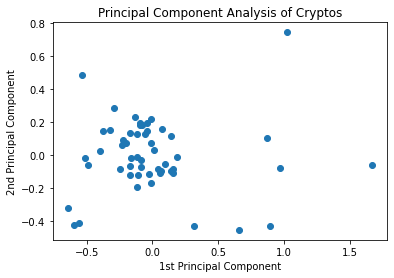

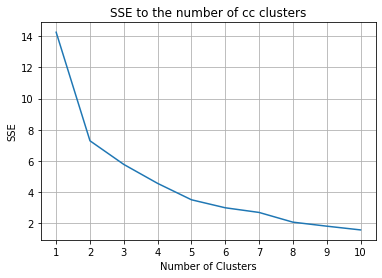

By looking through the different windows, taking 4 clusters would be on average appropriate 


In [17]:
# Clustering

# 2) PCA: Principal Components Analysis followed by a k-means clustering algorithm on its components
    # 2.a) Application on a single window

# PCA is firstly made
pca = PCA(n_components=3, random_state=123) # calling PCA function
pca.fit(frames_norm)
print(pca.explained_variance_)
principal_components = pd.DataFrame(pca.fit_transform(frames_norm), 
                                    index=frames_norm.index)

# from these variances, the number of components is determined
n_components = 3 #as the third component still explains more than 10% of the variance

loadings = pca.components_ # inspired by https://reneshbedre.github.io/blog/pca_3d.html
num_pc = pca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = frames_norm.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.title('Correlation map between three first components and variables')
plt.savefig('Clusters/pca_corrmap.eps',transparent=True)
plt.show()

# projecting log returns on two first components
plt.scatter(principal_components.iloc[:,0], principal_components.iloc[:,1])
plt.xlabel('1st Principal Component',fontsize=10)
plt.ylabel('2nd Principal Component',fontsize=10)
plt.title("Principal Component Analysis of Cryptos",fontsize=12)
plt.savefig('Clusters/pca.eps',transparent=True)
plt.show()

# Then, the k-means algorithm may be applied on this time-step

# To check the number of clusters needed
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init = "random", n_init=10, max_iter = 300,
                    random_state = 123)
    kmeans.fit(principal_components)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("SSE to the number of cc clusters",fontsize=12)
plt.grid(True)
plt.savefig('Clusters/pca_nb_kmeans.jpeg',transparent=True)
plt.show()

print("By looking through the different windows, taking 4 clusters would be on average appropriate ")
n_kmeans = 4
kmeans = KMeans(n_clusters=n_kmeans,random_state=123) # defining the function kmeans with the 

Let's try to divide the first window into four clusters:


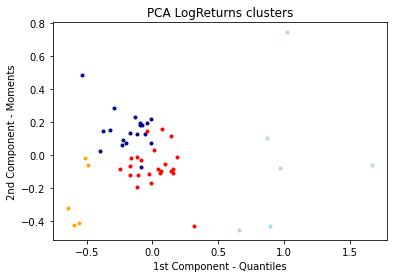

In [18]:
# clustering the first rolling window
print("Let's try to divide the first window into four clusters:")
label = kmeans.fit_predict(principal_components)
#print(label)

filtered_label0 = principal_components[label == 0]
filtered_label1 = principal_components[label == 1]
filtered_label2 = principal_components[label == 2]
filtered_label3 = principal_components[label == 3]

#Plotting the results
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(filtered_label0[0],filtered_label0[1], color='red', marker='.')
ax.scatter(filtered_label1[0],filtered_label1[1], color='lightblue', marker='.')
ax.scatter(filtered_label2[0],filtered_label2[1], color='orange', marker='.')
ax.scatter(filtered_label3[0],filtered_label3[1], color='darkblue', marker='.')
ax.set(title='PCA LogReturns clusters',ylabel='2nd Component - Moments',xlabel='1st Component - Quantiles')
plt.savefig('Clusters/PCA_clusters.jpeg',transparent=True)
plt.show()

In [19]:
del filtered_label0,filtered_label1,filtered_label2,filtered_label3

In [20]:
# Clustering

# 2) PCA: Principal Components Analysis followed by a k-means clustering algorithm on its components
    # 2.b) Application on all rolling windows

kmeans = KMeans(n_clusters=n_kmeans,random_state=123) # defining the function kmeans with the 
# optimal number of clusters found in last part
    
# Loop on the windows
labels = [] # creating a labels df for later
nt = len(window_mean);nb_cc; # time indices
timed_PCA = np.zeros((nt,nb_cc,n_components)) # 3D matrix for the PCA components at each time-step (days*nb_cc*nb_pc)
timed_PCA_label = np.zeros((nt,nb_cc)) # matrix for labels= in which cluster is a cc
#df = frames_norm

for i in range(nt):
    win_frames = [] 
    win_frames = [window_mean.iloc[i], window_var.iloc[i], 
                  window_skew.iloc[i], window_kurt.iloc[i],
                  window_005_quantile.iloc[i], window_010_quantile.iloc[i],
                  window_015_quantile.iloc[i], window_085_quantile.iloc[i], window_090_quantile.iloc[i],
                  window_095_quantile.iloc[i]] # computation of the rolling windows through time
    win_frames = pd.concat(win_frames, axis=1)
    win_frames_norm = pd.DataFrame(scaler.transform(win_frames),
                                   index=win_frames.index)
    # all rolling windows are created
    pca.fit(win_frames_norm) # the pca is initialized
    timed_PCA[i] = pca.fit_transform(win_frames_norm) # pca is done
    timed_PCA_label[i] = kmeans.fit_predict(timed_PCA[i]) # clusters labels are assigned to each cc

timed_PCA_label = pd.DataFrame(timed_PCA_label)
timed_PCA_label.columns = cc_names

# instead of analyzing each time-step, let's analyze the distribution of clusters assignation for each cc
index = pd.DataFrame([frames.index])
table = []
for i in index.transpose()[0]:
    y = timed_PCA_label[i].value_counts(normalize=True)
    table.append(y)
pca_km_table = pd.DataFrame(table)
del y,table;

print(pca_km_table) # printing table of interest

                            0.0       1.0       2.0       3.0
bitcoin                0.458824  0.158824  0.170588  0.211765
ethereum               0.461765  0.173529  0.185294  0.179412
ripple                 0.447059  0.167647  0.191176  0.194118
litecoin               0.458824  0.170588  0.191176  0.179412
bitcoin-cash           0.552941  0.167647  0.141176  0.138235
chainlink              0.408824  0.167647  0.235294  0.188235
binancecoin            0.514706  0.152941  0.185294  0.147059
cardano                0.494118  0.147059  0.208824  0.150000
stellar                0.517647  0.164706  0.161765  0.155882
usd-coin               0.370588  0.123529  0.208824  0.297059
bitcoin-cash-sv        0.458824  0.191176  0.205882  0.144118
eos                    0.417647  0.191176  0.211765  0.179412
nem                    0.461765  0.214706  0.152941  0.170588
tron                   0.488235  0.161765  0.205882  0.144118
okb                    0.391176  0.214706  0.214706  0.179412
tezos   

Let's see how cc log returns are clustered for some rolling windows


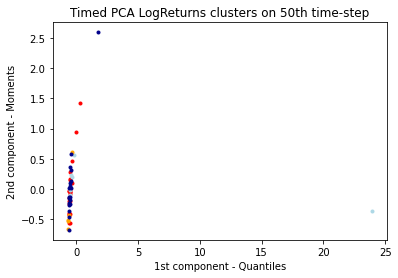

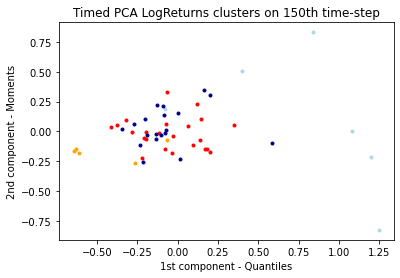

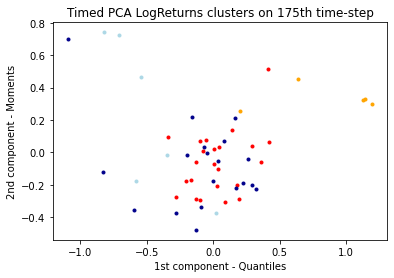

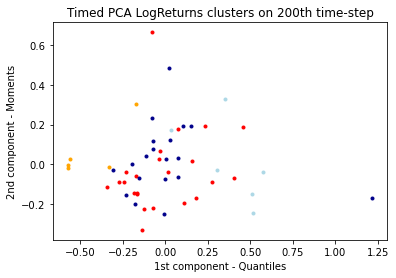

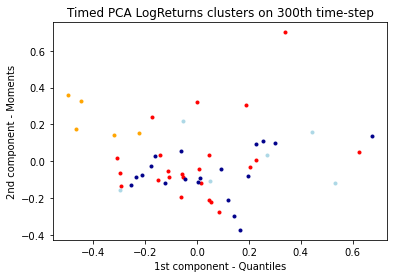

In [21]:
# Plotting the results for some rolling windows
print("Let's see how cc log returns are clustered for some rolling windows")
rw_choice = [50,150,175,200,300]
rw_choice

for r in rw_choice:
    selected_ts = r
    filtered_data = timed_PCA[selected_ts]
    filtered_label0 = filtered_data[label == 0]
    filtered_label1 = filtered_data[label == 1]
    filtered_label2 = filtered_data[label == 2]
    filtered_label3 = filtered_data[label == 3]
    
        #Plotting the results
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(filtered_label0[:,0],filtered_label0[:,1], color='red', marker='.')
    ax.scatter(filtered_label1[:,0],filtered_label1[:,1], color='lightblue', marker='.')
    ax.scatter(filtered_label2[:,0],filtered_label2[:,1], color='orange', marker='.')
    ax.scatter(filtered_label3[:,0],filtered_label3[:,1], color='darkblue', marker='.')
    ax.set(title='Timed PCA LogReturns clusters on '+str(selected_ts) + 'th time-step',ylabel='2nd component - Moments',xlabel='1st component - Quantiles')
    plt.savefig('Clusters/timedpca_clusters'+str(selected_ts)+'rw.jpeg',transparent=True)
    plt.show()


In [22]:
del r, rw_choice,filtered_label0,filtered_label1,filtered_label2,label

In [23]:
# Distribution of cc log returns in clusters
pca_km_table = pca_km_table.round(2)

print("Here is the distribution of cc log returns in each cluster:")
print(pca_km_table)

pca_km_table1 = pd.DataFrame(pca_km_table[:17])
pca_km_table2 = pd.DataFrame(pca_km_table[17:34])
pca_km_table3 = pd.DataFrame(pca_km_table[34:])


pca_km_table1.to_csv('Clusters/pca_km_table1.csv', index=True, header=True)
pca_km_table2.to_csv('Clusters/pca_km_table2.csv', index=True, header=True)
pca_km_table3.to_csv('Clusters/pca_km_table3.csv', index=True, header=True)

Here is the distribution of cc log returns in each cluster:
                        0.0   1.0   2.0   3.0
bitcoin                0.46  0.16  0.17  0.21
ethereum               0.46  0.17  0.19  0.18
ripple                 0.45  0.17  0.19  0.19
litecoin               0.46  0.17  0.19  0.18
bitcoin-cash           0.55  0.17  0.14  0.14
chainlink              0.41  0.17  0.24  0.19
binancecoin            0.51  0.15  0.19  0.15
cardano                0.49  0.15  0.21  0.15
stellar                0.52  0.16  0.16  0.16
usd-coin               0.37  0.12  0.21  0.30
bitcoin-cash-sv        0.46  0.19  0.21  0.14
eos                    0.42  0.19  0.21  0.18
nem                    0.46  0.21  0.15  0.17
tron                   0.49  0.16  0.21  0.14
okb                    0.39  0.21  0.21  0.18
tezos                  0.39  0.19  0.29  0.12
neo                    0.49  0.16  0.21  0.14
celsius-degree-token   0.24  0.23  0.32  0.21
theta-token            0.42  0.19  0.23  0.16
dash                

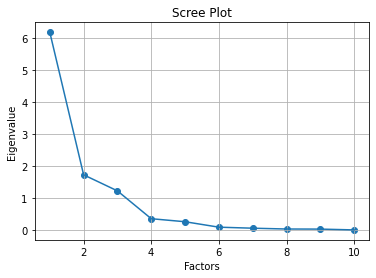

The number of variables should be reduced to three since it's the number of eigen values above 1 (which signifies that a factor is able to explain more than a single variable).


In [44]:
# Clustering

# 3) LFM: Linear Factor Model followed by a k-means clustering algorithm on its factors
    # 3.a) Application on a single window

# Initialization: Firstly, test if it makes sense to make a LFM

# It checks whether variables are correlated or not. If significant, ok. If not, a factor
# analysis should not be done. 
chi_square_value,p_value = calculate_bartlett_sphericity(frames_norm)
chi_square_value, p_value
# It seems to be statistically significant so we can continue. 

# It computes a score of the suitability of the data to a Factor Analysis
kmo_all,kmo_model=calculate_kmo(frames_norm)
kmo_model
# 0.715 seems ok

# Creating factor analysis object and perform factor analysis
fa = FactorAnalyzer()
fa_test = fa.analyze(frames_norm, 4)

# Checking eigen values: it will show us the number of significant factors

# Computing Eigenvalues
ev, v = fa.get_eigenvalues()
ev

# Creating a scree plot to display the different eigen values
plt.scatter(range(1,frames_norm.shape[1]+1),ev)
plt.plot(range(1,frames_norm.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.savefig('Clusters/lfm_scree.jpeg',transparent=True)
plt.show()

n_factors = 3
fa = FactorAnalyzer()
fa_test = fa.analyze(frames_norm, n_factors)
print("The number of variables should be reduced to three since it's the number of eigen values above 1 (which signifies that a factor is able to explain more than a single variable).")

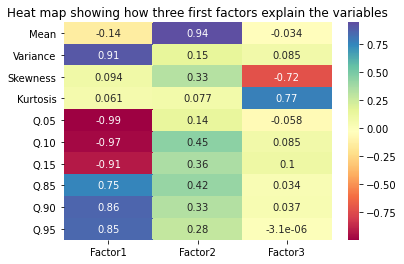

In [50]:
loadings_lfm = pd.DataFrame(fa.loadings)
ax = sns.heatmap(loadings_lfm, annot=True, cmap='Spectral')
plt.title('Heat map showing how three first factors explain the variables')
plt.savefig('Clusters/lfm_heatmap.jpeg',transparent=True)
plt.show()


In [51]:
del sse,k,kmeans,n_kmeans

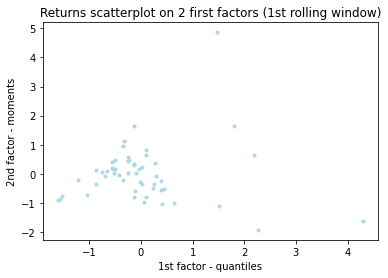

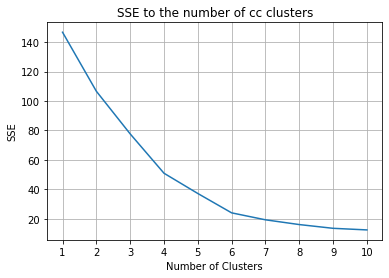

Again, taking 4 clusters seems to be a good tradeoff between precision and differentiation


In [53]:
# Linear Factor model estimation

# Application on the first rolling window

frames_norm_np = np.array(frames_norm)

fanalysis = FactorAnalysis(n_components=n_factors)
df_3d = fanalysis.fit_transform(frames_norm_np); df_3d = pd.DataFrame(df_3d)
df_3d.columns = ["Factor1","Factor2","Factor3"]
df_3d.index = cc_names

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(df_3d['Factor1'],df_3d['Factor2'], color='lightblue', marker='.')
ax.set(title='Returns scatterplot on 2 first factors (1st rolling window)',ylabel='2nd factor - moments',xlabel='1st factor - quantiles')
plt.savefig('Clusters/lfm_sc.jpeg',transparent=True)
plt.show()

mu = np.mean(frames_norm.transpose())
Y = returns_data.iloc[0];Y
X = np.zeros((len(frames_norm),3))
X[:,0] = df_3d['Factor1'];X[:,1] = df_3d['Factor2']; X[:,2] = mu
mlr = LinearRegression().fit(X,Y)

regressor = LinearRegression()
regressor.fit(X,Y)
regressor.coef_

# Then, the k-means algorithm may be applied on this time-step

# To check the number of clusters needed. The criteria is the sse (sum of squared errors). 
# Searching for the smallest one, a tradeoff needs to be found between a small sse but a small number of kmeans.
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init = "random", n_init=10, max_iter = 300,
                    random_state = 123)
    kmeans.fit(df_3d)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("SSE to the number of cc clusters",fontsize=12)
plt.grid(True)
plt.savefig('Clusters/lfm_nb_kmeans.jpeg',transparent=True)
plt.show()

print("Again, taking 4 clusters seems to be a good tradeoff between precision and differentiation")
n_kmeans = 4

[3 3 3 0 3 0 3 0 3 3 3 3 3 0 3 3 0 0 0 3 0 2 3 3 3 3 3 0 3 3 3 3 0 3 0 3 3
 0 3 3 0 0 0 2 3 0 0 3 3 1 0 0 3]


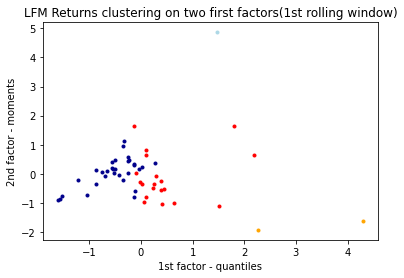

In [56]:
# Now we know the number of clusters we want, let's try it for the first rolling window. 

# initialize kmeans class object
kmeans = KMeans(n_clusters = n_kmeans,random_state=123) # defining the function kmeans
#predict the labels of clusters.
label = kmeans.fit_predict(df_3d)
print(label)

#Getting unique labels

u_labels = np.unique(label)

#filter rows of original data: it separates the data into the different clusters
filtered_label0 = df_3d[label == 0]
filtered_label1 = df_3d[label == 1]
filtered_label2 = df_3d[label == 2]
filtered_label3 = df_3d[label == 3]

#Plotting the results
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(filtered_label0['Factor1'],filtered_label0['Factor2'], color='red', marker='.')
ax.scatter(filtered_label1['Factor1'],filtered_label1['Factor2'], color='lightblue', marker='.')
ax.scatter(filtered_label2['Factor1'],filtered_label2['Factor2'], color='orange', marker='.')
ax.scatter(filtered_label3['Factor1'],filtered_label3['Factor2'], color='darkblue', marker='.')
ax.set(title='LFM Returns clustering on two first factors(1st rolling window)',ylabel='2nd factor - moments',xlabel='1st factor - quantiles')
plt.savefig('Clusters/lfm_clusters.jpeg',transparent = True)
plt.show()

In [57]:
# Clustering

# 3) LFM: Linear Factor Model followed by a k-means clustering algorithm on its factors
    # 3.b) Application on all rolling windows

# Timed linear factor model
nt = len(window_mean)
nb_cc = len(frames_norm)
labels = []
timed_LFM = np.zeros((nt,nb_cc,n_factors)) # 3D matrix for the projection of cc returns on two factors
timed_label = np.zeros((nt,nb_cc)) # output matrix with the clusters labels for each cc


for i in range(nt):
    win_frames = []
    win_frames = [window_mean.iloc[i],window_var.iloc[i], window_skew.iloc[i], 
                  window_kurt.iloc[i], window_005_quantile.iloc[i], window_010_quantile.iloc[i],
                  window_015_quantile.iloc[i], window_085_quantile.iloc[i], window_090_quantile.iloc[i],
                  window_095_quantile.iloc[i]]
    win_frames = pd.concat(win_frames, axis=1)
    win_frames_norm = pd.DataFrame(scaler.transform(win_frames),
                                   index=win_frames.index)
    timed_LFM[i] = fanalysis.fit_transform(win_frames_norm)
    timed_label[i] = kmeans.fit_predict(timed_LFM[i])

timed_label = pd.DataFrame(timed_label)
timed_label.columns = cc_names

Let's see how cc log returns are clustered for some rolling windows


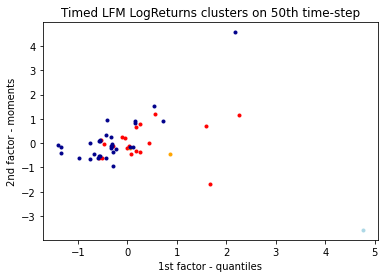

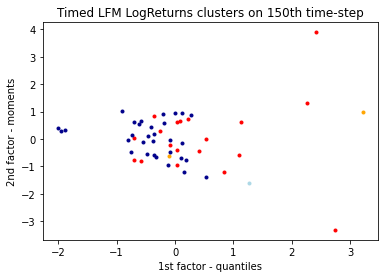

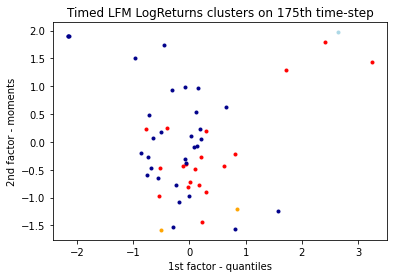

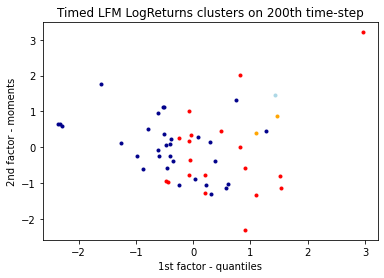

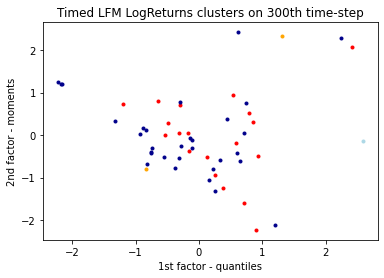

In [58]:
# Plotting the results for some rolling windows
print("Let's see how cc log returns are clustered for some rolling windows")
rw_choice = [50,150,175,200,300]
rw_choice

for r in rw_choice:
    selected_ts = r
    filtered_data = timed_LFM[selected_ts]
    filtered_label0 = filtered_data[label == 0]
    filtered_label1 = filtered_data[label == 1]
    filtered_label2 = filtered_data[label == 2]
    filtered_label3 = filtered_data[label == 3]
    
        #Plotting the results
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(filtered_label0[:,0],filtered_label0[:,1], color='red', marker='.')
    ax.scatter(filtered_label1[:,0],filtered_label1[:,1], color='lightblue', marker='.')
    ax.scatter(filtered_label2[:,0],filtered_label2[:,1], color='orange', marker='.')
    ax.scatter(filtered_label3[:,0],filtered_label3[:,1], color='darkblue', marker='.')
    ax.set(title='Timed LFM LogReturns clusters on '+str(selected_ts) + 'th time-step',ylabel='2nd factor - moments',xlabel='1st factor - quantiles')
    plt.savefig('Clusters/timedlfm_clusters'+str(selected_ts)+'rw.eps',transparent=True)
    plt.show()
    

In [ ]:
# Distribution of cc log returns in clusters

index = pd.DataFrame([frames.index])
lfm_distribution = []
for i in index.transpose()[0]:
    y = timed_label[i].value_counts(normalize=True)
    lfm_distribution.append(y)
lfm_distribution = pd.DataFrame(lfm_distribution);lfm_distribution = lfm_distribution.round(2)
lfm_distribution.columns = ["Cluster1","Cluster2","Cluster3","Cluster4"]

print("Here is the distribution of cc log returns in each cluster:")
print(lfm_distribution)

lfm_distribution1 = pd.DataFrame(lfm_distribution[:17])
lfm_distribution2 = pd.DataFrame(lfm_distribution[17:34])
lfm_distribution3 = pd.DataFrame(lfm_distribution[34:])


lfm_distribution1.to_csv('Clusters/LFM_distribution1.csv', index=True, header=True)
lfm_distribution2.to_csv('Clusters/LFM_distribution2.csv', index=True, header=True)
lfm_distribution3.to_csv('Clusters/LFM_distribution3.csv', index=True, header=True)